### Code to create images for use with CT_Tutorial.ipynb

First some imports and parameters

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imwrite
import os

NUM_IMAGES = 5
IMAGE_WIDTH = 512

DATATYPE = np.uint16
MAXINT = 2**16-1



Some code to create collections of generalized ellipses of specified size, position, orientation, and intensity.  For this code, the position are specified on a scale of -1 to 1 representing the edges of the image, and the size is in the range 0 to 1, with 1 representing the full width of the image.  

In [8]:
def make_phantom(ellipse, img_width):
    """
    Create a phantom with specified ellipses
    P = phantom(E,N) generates a user-defined phantom, where each row
    of the matrix E specifies an ellipse in the image.  E has 7 columns,
    with each column containing a different parameter for the ellipses:
   
     Column 0:  A    the intensity value of the ellipse
     Column 1:  s    the standard deviation of additive noise for A
     Column 2:  a    the length of the horizontal semi-axis of the ellipse 
     Column 3:  b    the length of the vertical semi-axis of the ellipse
     Column 4:  x0   the x-coordinate of the center of the ellipse
     Column 5:  y0   the y-coordinate of the center of the ellipse
     Column 6:  phi  the angle (in degrees) between the horizontal semi-axis 
                     of the ellipse and the x-axis of the image   
     Column 7:  fill 1 if the ellipse is filled, 0 otherwise  
     Column 8:  pow  2 for ellipse, higher for closer to rectangle

   For purposes of generating the phantom, the domains for the x- and 
   y-axes span [-1,1].  Columns 2 through 5 must be specified in terms
   of this range.
    """   
    num_ells = ellipse.shape[0]
    eps = 1e-7

    n = img_width
    p = np.zeros((n,n))

    xax =  ( np.arange(n)-(n-1)/2 ) / ((n-1)/2)
    xg = np.tile(xax, (n, 1))   # x coordinates, the y coordinates are rot90(xg)

    for k in np.arange(num_ells-1,-1,-1):
        pow = ellipse[k,8]
        asq = ellipse[k,2]**pow + eps      
        bsq = ellipse[k,3]**pow + eps      
        phi = ellipse[k,6]*np.pi/180  # rotation angle in radians
        x0 = ellipse[k,4]          # x offset
        y0 = ellipse[k,5]         # y offset
        A = ellipse[k,0]           # Intensity for this ellipse
        x=xg-x0                   # Center the ellipse
        y=np.rot90(xg)-y0  
        cosp = np.cos(phi) 
        sinp = np.sin(phi)

        a = (np.abs(x*cosp + y*sinp)**pow + eps)/asq + (np.abs(y*cosp - x*sinp)**pow + eps)/bsq
        if ellipse[k,7]:
            idx = (a <= 1)
        else:
            idx = (a>0.85) * (a <= 1)

        s = ellipse[k,1]
        noise = s*np.random.randn(n,n)
        if (k > 0):
            p[idx] = np.amax(np.stack((p[idx], A + noise[idx]), axis=-1), axis=-1)
        else:
            p[idx] = A + noise[idx]
            idx = (a > 1)
            p[idx] = 0
    return p 
  

Some utility functions.  One to get a set of intensities for objects in the images, and another to convert to the correct data type to store HDR images.  

In [9]:
def get_weights(i, j):
    wts = 12000*np.random.power(0.3, size=(i,j))
    plt.figure(1)
    plt.clf()
    plt.hist(wts.flatten(), bins=10)
    plt.title('Histogram of object intensities')
    sd = wts/6
    return wts, sd

def convert_for_save(data):
    return data.astype(DATATYPE)
   


Code to create images, which are created as a collection of generalized ellipses using the code above.  This code sets the corresponding weights and parameters and calls the code above to create the images.  

In [10]:
def create_samples(num_samples, ground_width):
        
    width = ground_width
    
    # Get inputs and noise and determine size of sinogram
    ground_data = np.zeros((num_samples, width, width), dtype=DATATYPE)     
                         
    # Iterate over samples
    # Create num_overlays separate binary blobs and take a linear 
    # combination specified by wts
    num_overlays = 4
    num_ell_array = np.floor(12 + np.random.rand(num_samples)*5).astype('int')
    max_ell = np.amax(num_ell_array)

    wts, sd = get_weights(num_samples, np.amax(np.array([max_ell, num_overlays])))
    ten_percent = max(5, num_samples // 10)
    
    for k in range(num_samples):
        if (k % ten_percent == 0):
            print(str(k) + ' of ' + str(num_samples))
            
        num_ell = num_ell_array[k]
        ell = np.zeros((num_ell, 9))
        
        # Set the dense objects
        ell[:,0] = wts[k, 0:num_ell].flatten() # intensity
        ell[:,1] = sd[k, 0:num_ell].flatten() # std dev of noise
        ell[:,2:4] = np.random.rand(num_ell, 2)/4  # axes lengths      
        ell[:, 4:6] = np.random.rand(num_ell,2) - 0.5 # centers
        ell[:, 6] = np.random.rand(num_ell)*360 # angles
        ell[:,7] = np.round(np.random.rand(num_ell)) # filled or not
        ell[:,8] = 1 + 1.0/np.random.rand(num_ell) # shape exponent
        
        # Set the background
        ell[-4:,0] = 100 + 300*np.random.rand(4) # intensity
        ell[-4:,1] = 70 # std dev
        ell[-4:,2:4] = 0.3 + 0.2*np.random.rand(4,2) # width, height
        ctrs = np.array([1, 1, 1, -1, -1, 1, -1, -1], dtype=float)/3.
        ell[-4:,4:6] = np.resize(ctrs, (4,2)) + (np.random.rand(4,2)-0.5)/8 # center
        ell[-4:,6] = 0 # angle=0
        ell[-4:,7] = 1 # filled
        ell[-4:,8] = 4 + np.random.randint(0,4,size=(4)) # shape exponent
       
        # set the outline
        ell[0,0] = 1500 + 200*np.random.rand(1) # intensity
        ell[0,1] = 100 # std dev
        ell[0,2] = 0.75 # width
        ell[0,3] = 0.65 # height
        ell[0,4:8] = 0 # center=0, angle=0, not filled
        ell[0,8] = 10 # shape exponent
        ground = make_phantom(ell, width)
                
        # Create the training data:  ground truth and rotated low-res
        ground_data[k, :, :] = convert_for_save(ground)
        
    cur_data = ground_data[0,:,:].flatten()
    plt.figure(3)
    plt.clf()
    plt.hist(cur_data[(cur_data>200) * (cur_data<2000)], bins=100)
    plt.title('Partial histogram for image 0')
    plt.figure(4)
    plt.clf()
    plt.hist(cur_data[cur_data>2000], bins=100)
    plt.title('Partial histogram for image 0')

    return ground_data
   

Code to show some sample images with varying scales and to save images.  

In [19]:
# Show a sample of images
def show_sample(ground):
    # For use with nondisplaying servers - leave out if running locally or on notebook
    #plt.switch_backend('agg')  
        
    n = 3  # how many examples we will display

    startInd = 0 # np.random.randint(in_test.shape[0]-n)
    print('Starting at image ' + str(startInd))
    plt.close(2)
    plt.figure(2, figsize=(20, 8))
    
    vmin = [0, 0, 2000, 8000]
    vmax = [1000, 2000, 8000, 15000]
    num_scales = len(vmin)
    #plt.suptitle('Images')
    for i in range(n):
        curInd = startInd + i
        
        for k in range(num_scales):
            # display at various scales
            ax = plt.subplot(n,num_scales, i*num_scales + k + 1)
            plt.imshow(ground[curInd,:,:], vmin=vmin[k], vmax=vmax[k])
            #plt.title('Ground truth')
            plt.colorbar()
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)   

    plt.tight_layout()
    plt.savefig('./images/test.png')
    plt.show()
   
    return

def save_images(ground_data):
    os.makedirs('images', exist_ok=True)
    max_ind = ground_data.shape[0]
    pow10 = 10**np.ceil(np.log10(max_ind))
    for j in range(max_ind):
        cur_str = str(pow10.astype(int) + j)
        filename = 'images/image' + cur_str[1:] + '.png'
        imwrite(filename, ground_data[j,:,:].astype(np.uint16))


Code that calls the methods above to create the images.  

0 of 15
5 of 15
10 of 15
Starting at image 0


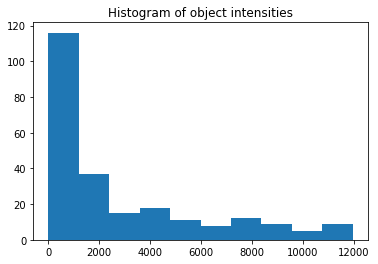

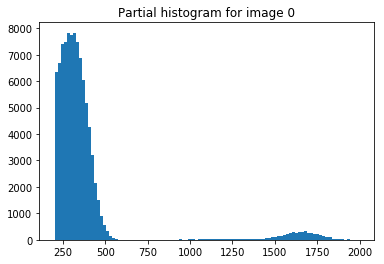

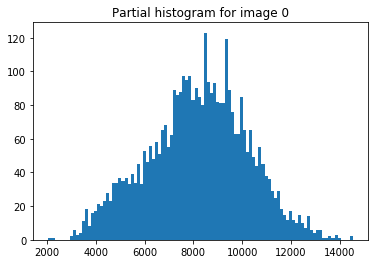

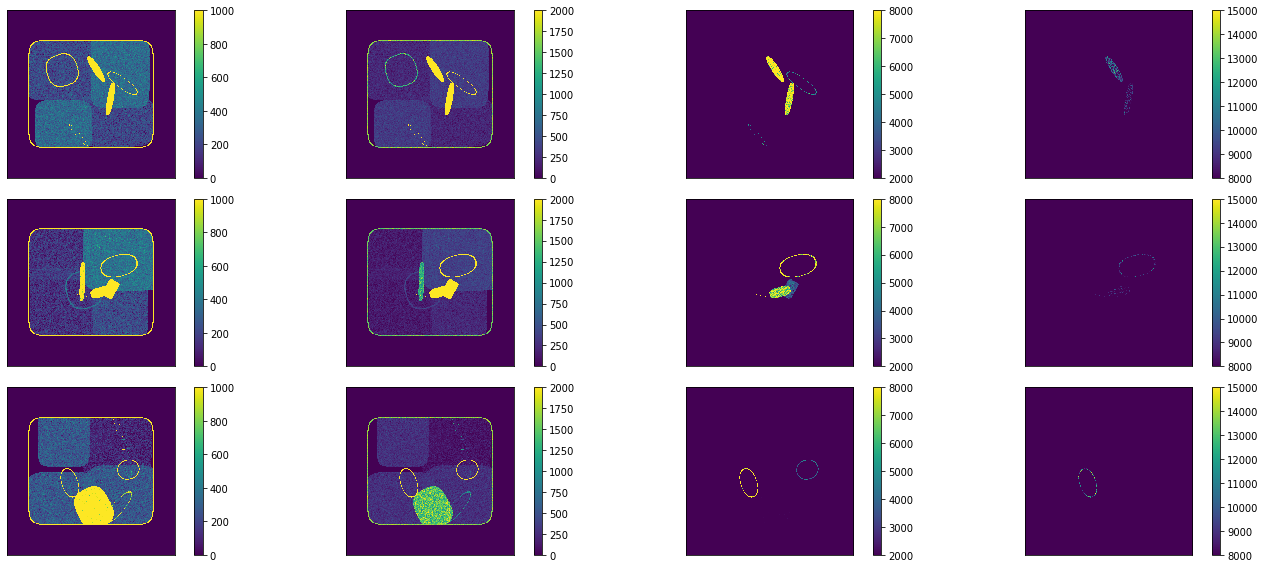

In [22]:
    num_samples = 15# NUM_IMAGES
    img_width = IMAGE_WIDTH
   
    ground = create_samples(num_samples, img_width)
    
    os.makedirs('images', exist_ok=True)
    show_sample(ground)
    save_images(ground)
